In [36]:
# Team 1 LendingClub primary notebook
# import dependencies
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress, spearmanr

# PROCESSING OF LENDING CLUB LOAN FILES

# pull in all csvs and merge them into a single dataframe
bigdf = pd.concat([pd.read_csv(f, low_memory=False, 
                               usecols=[
                                   'loan_amnt','term','int_rate','installment','emp_length',
                                   'home_ownership','annual_inc','issue_d','loan_status',
                                   'pymnt_plan','purpose','title','addr_state','dti',
                                   'delinq_2yrs','mths_since_last_delinq','open_acc','pub_rec',
                                   'total_rec_late_fee','recoveries','collection_recovery_fee',
                                   'mths_since_last_major_derog','chargeoff_within_12_mths',
                                   'delinq_amnt','mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
                                   'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',
                                   'mths_since_recent_bc','mths_since_recent_bc_dlq',
                                   'mths_since_recent_inq','mths_since_recent_revol_delinq',
                                   'pct_tl_nvr_dlq','pub_rec_bankruptcies','tax_liens'
                               ]) 
                   for f in glob.glob('data/LoanStats*.csv')], ignore_index=True)


# code to fill nans with 0s
bigdf['mths_since_last_major_derog'].replace(np.nan, 0)

# processing date into new columns
bigdf["month_num"] = ""
bigdf.loc[bigdf['issue_d'].str[:3] == "Dec", ('month_num')] = (12)
bigdf.loc[bigdf['issue_d'].str[:3] == "Nov", ('month_num')] = (11)
bigdf.loc[bigdf['issue_d'].str[:3] == "Oct", ('month_num')] = (10)
bigdf.loc[bigdf['issue_d'].str[:3] == "Sep", ('month_num')] = (9)
bigdf.loc[bigdf['issue_d'].str[:3] == "Aug", ('month_num')] = (8)
bigdf.loc[bigdf['issue_d'].str[:3] == "Jul", ('month_num')] = (7)
bigdf.loc[bigdf['issue_d'].str[:3] == "Jun", ('month_num')] = (6)
bigdf.loc[bigdf['issue_d'].str[:3] == "May", ('month_num')] = (5)
bigdf.loc[bigdf['issue_d'].str[:3] == "Apr", ('month_num')] = (4)
bigdf.loc[bigdf['issue_d'].str[:3] == "Mar", ('month_num')] = (3)
bigdf.loc[bigdf['issue_d'].str[:3] == "Feb", ('month_num')] = (2)
bigdf.loc[bigdf['issue_d'].str[:3] == "Jan", ('month_num')] = (1)
bigdf.loc[bigdf['issue_d'].str[:3] == "", ('month_num')] = (0)

# clean up the dead rows
bigdf.dropna(subset=['term', 'issue_d'], inplace=True)

# PROCESSING OF FEMA DISASTER FILE

# read in FEMA csv file into dataframe
fema = pd.read_csv('data/DisasterDeclarationsSummaries.csv')

# drop columns that are irrelevant
fema = fema.loc[:, ['disasterNumber', 'state', 'incidentBeginDate',
                'incidentType', 'incidentEndDate']]

# create columns to link with lendingclub.com data
fema['yearBegin'] = fema['incidentBeginDate'].str[:4]
fema['monthBegin'] = fema['incidentBeginDate'].str[5:7]
fema['monthEnd'] = fema['incidentEndDate'].str[5:7]

# drop unix dates from dataframe
fema = fema.loc[:, ['disasterNumber', 'state', 'incidentType', 'yearBegin',
                'monthBegin', 'monthEnd']]

# drop all data outside of 2018
fema = fema[fema['yearBegin'] == '2018']

# drop duplicate rows with same incident named for multiple counties
fema.drop_duplicates(subset=['incidentType','disasterNumber', 'yearBegin','monthBegin','monthEnd'], inplace=True)

# fill in all ending month with beginning month if it is missing
fema.monthEnd.fillna(fema.monthBegin, inplace=True)

# drop irrelevant disasterNumber
fema.drop(columns=['disasterNumber'], inplace=True)

# convert month number strings to numeric
fema['monthBegin'] = fema['monthBegin'].apply(pd.to_numeric, errors='coerce')
fema['monthEnd'] = fema['monthEnd'].apply(pd.to_numeric, errors='coerce')
fema['aftermath'] = fema['monthEnd'] + 1

# reinforce the numeric status of loan month number
bigdf['month_num'] = bigdf['month_num'].apply(pd.to_numeric, errors='coerce')

# clean up the dead rows
fema.dropna(subset=['monthBegin', 'monthEnd'], inplace=True)
# write to csv
# fema.to_csv('data/fema_clean.csv', index=False)

bigdf = bigdf.reset_index(drop=True)

In [37]:
# CREATING TRIGGER MARKS IN LENDING CLUB BASED ON FEMA

def checkDisaster(row):
    global fema
    tmp_df = fema[(row['month_num'] >= fema['monthBegin']) 
                  & (row['month_num'] <= fema['monthEnd'])
                  & (fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'D'
    else:
        return 'N'
    
def checkAftermath(row):
    global fema
    tmp_df = fema[(row['month_num'] == fema['monthEnd']+1)
                  & (fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'A'
    else:
        return 'N'

def checkDState(row):
    global fema
    tmp_df = fema[(fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'T'
    else:
        return 'F'

bigdf["Disaster"] = ""
bigdf["DState"] = ""
bigdf["Aftermath"] = ""    
    
bigdf['Disaster'] = bigdf.apply(lambda x: checkDisaster(x), axis=1)
bigdf['DState'] = bigdf.apply(lambda x: checkDState(x), axis=1)
bigdf['Aftermath'] = bigdf.apply(lambda x: checkAftermath(x), axis=1)

bigdf.to_csv('data/data_fema_compare.csv', index=False)

In [38]:
bigdf.head()


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,pymnt_plan,...,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,month_num,Disaster,DState,Aftermath
0,30000.0,36 months,7.34%,930.99,3 years,OWN,95000.0,Mar-18,Fully Paid,n,...,NaN,24.0,10.0,90.0,0.0,0.0,3,N,T,N
1,34825.0,60 months,12.61%,785.45,2 years,MORTGAGE,125000.0,Mar-18,Current,n,...,45.0,15.0,45.0,96.3,0.0,0.0,3,N,T,N
2,2600.0,36 months,7.96%,81.43,3 years,MORTGAGE,62000.0,Mar-18,Current,n,...,NaN,NaN,NaN,100.0,0.0,0.0,3,N,T,N
3,20000.0,60 months,9.92%,424.16,3 years,MORTGAGE,110000.0,Mar-18,Current,n,...,NaN,4.0,NaN,90.9,0.0,0.0,3,N,T,N
4,17000.0,60 months,20.39%,454.10,10+ years,RENT,52000.0,Mar-18,Current,n,...,77.0,0.0,77.0,85.7,0.0,0.0,3,N,T,N


In [39]:
fema = fema.reset_index(drop=True)
fema.head()

,state,incidentType,yearBegin,monthBegin,monthEnd,aftermath
0,AS,Hurricane,2018,2,2,3
1,AS,Hurricane,2018,2,2,3
2,OK,Fire,2018,3,3,4
3,KY,Flood,2018,2,2,3
4,WV,Mud/Landslide,2018,2,2,3


In [1]:
# make two smaller dataframes: one that is with disasters, one without disasters. 
# Set up 1 Sample Test
disaster_df = bigdf[bigdf['DState'] == 'T']
disaster_samp = disaster_df.loc[:,["loan_amnt", "addr_state", "month_num", "Disaster", "DState", "Aftermath"]]
disaster_samp = disaster_samp.groupby(['month_num']).count()

bigdf_pop = bigdf.loc[:,["loan_amnt", "addr_state", "month_num", "Disaster", "DState", "Aftermath"]]
bigdf_pop = bigdf_pop.groupby(['month_num']).count()

population = list(bigdf_pop.loan_amnt)
sample = list(disaster_samp.loan_amnt)

NameError: name 'bigdf' is not defined

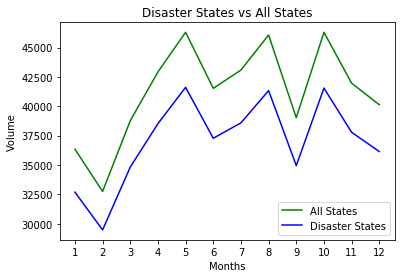

In [41]:
# Create a list of the months that we will use as our x axis
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, population, color="green", label="All States")

# Plot our line that will be used to track a wrestler's losses over the years
plt.plot(months, sample, color="blue", label="Disaster States")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Disaster States vs All States")
plt.xlabel("Months")
plt.ylabel("Volume")

plt.xticks(months)

# Print our chart to the screen
plt.show()


In [42]:
fema

,state,incidentType,yearBegin,monthBegin,monthEnd,aftermath
0,AS,Hurricane,2018,2,2,3
1,AS,Hurricane,2018,2,2,3
2,OK,Fire,2018,3,3,4
3,KY,Flood,2018,2,2,3
4,WV,Mud/Landslide,2018,2,2,3
5,OH,Flood,2018,2,2,3
6,OK,Fire,2018,4,4,5
7,OK,Fire,2018,4,4,5
8,TX,Fire,2018,4,4,5
9,TX,Fire,2018,4,4,5


In [43]:
# pick two states with the most disasters
fema_tot_count = fema.groupby(["state"]).count()
fema_tot_count

,incidentType,yearBegin,monthBegin,monthEnd,aftermath
state,,,,,
AK,3,3,3,3,3
AL,3,3,3,3,3
AS,2,2,2,2,2
AZ,4,4,4,4,4
CA,16,16,16,16,16
CO,3,3,3,3,3
CT,2,2,2,2,2
FL,3,3,3,3,3
GA,2,2,2,2,2


In [45]:
fema_type_count = fema.groupby(["incidentType"])['state'].count()
fema_type_count


incidentType
Coastal Storm       3
Earthquake          2
Fire               56
Flood              19
Hurricane          20
Mud/Landslide       1
Severe Storm(s)    19
Snow                3
Tornado             1
Typhoon             2
Volcano             1
Name: state, dtype: int64

In [82]:
state1_df = disaster_df[disaster_df["addr_state"] == 'VA']
state2_df = disaster_df[disaster_df["addr_state"] == 'WV']


In [69]:
state1_d_df = state1_df[state1_df["Disaster"] == 'D']
state1_d_count = state1_d_df.groupby(["month_num"])["loan_amnt"].count()
state1_d_count

month_num
9      987
10    1169
Name: loan_amnt, dtype: int64

In [83]:
state2_d_df = state2_df[state2_df["Disaster"] == 'D']
state2_d_count = state2_d_df.groupby(["month_num"])["loan_amnt"].count()
state2_d_count

month_num
2    215
5    317
6    228
Name: loan_amnt, dtype: int64

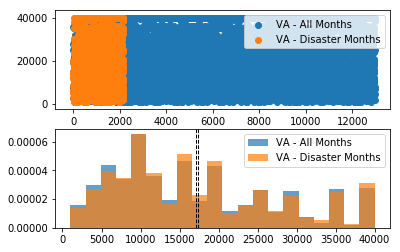

In [84]:
vapopulation = np.array(list(state1_df.loan_amnt))
vasample = np.array(list(state1_d_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(vapopulation)), vapopulation, label="VA - All Months")
plt.scatter(range(len(vasample)), vasample, label="VA - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(vapopulation, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(vasample, 20, density=True, alpha=0.7, label="VA - Disaster Months")
plt.axvline(vapopulation.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(vasample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()


In [86]:
stats.ttest_1samp(vasample, vapopulation.mean())

Ttest_1sampResult(statistic=0.9092917389993791, pvalue=0.3632978317944181)

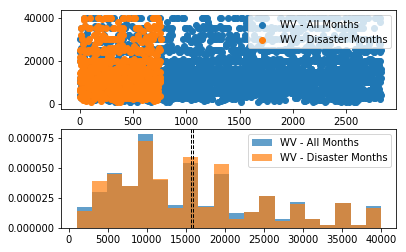

In [85]:
wvpopulation = np.array(list(state2_df.loan_amnt))
wvsample = np.array(list(state2_d_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wvpopulation)), wvpopulation, label="WV - All Months")
plt.scatter(range(len(wvsample)), wvsample, label="WV - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wvpopulation, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wvsample, 20, density=True, alpha=0.7, label="WV - Disaster Months")
plt.axvline(wvpopulation.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wvsample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [87]:
stats.ttest_1samp(wvsample, wvpopulation.mean())

Ttest_1sampResult(statistic=-0.5362342559632381, pvalue=0.5919537786233782)

In [92]:
# Checking aftermath loan sizes
state1_a_df = state1_df[state1_df["Aftermath"] == 'A']
state1_a_count = state1_a_df.groupby(["month_num"])["loan_amnt"].count()
state1_a_count

month_num
10    1169
11    1164
Name: loan_amnt, dtype: int64

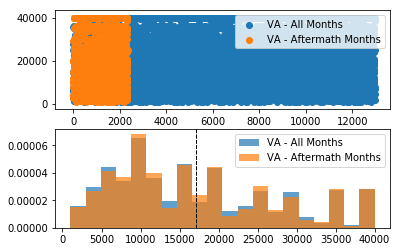

In [93]:
va_a_population = np.array(list(state1_df.loan_amnt))
va_a_sample = np.array(list(state1_a_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(va_a_population)), va_a_population, label="VA - All Months")
plt.scatter(range(len(va_a_sample)), va_a_sample, label="VA - Aftermath Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(va_a_population, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(va_a_sample, 20, density=True, alpha=0.7, label="VA - Aftermath Months")
plt.axvline(va_a_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(va_a_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [94]:
stats.ttest_1samp(va_a_sample, va_a_population.mean())

Ttest_1sampResult(statistic=-0.05838991874207314, pvalue=0.9534430474445266)

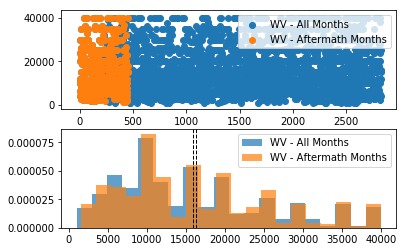

In [103]:
# Checking aftermath loan sizes
state2_a_df = state2_df[state2_df["Aftermath"] == 'A']
state2_a_count = state2_a_df.groupby(["month_num"])["loan_amnt"].count()

wv_a_population = np.array(list(state2_df.loan_amnt))
wv_a_sample = np.array(list(state2_a_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wv_a_population)), wv_a_population, label="WV - All Months")
plt.scatter(range(len(wv_a_sample)), wv_a_sample, label="WV - Aftermath Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wv_a_population, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wv_a_sample, 20, density=True, alpha=0.7, label="WV - Aftermath Months")
plt.axvline(wv_a_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wv_a_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [96]:
stats.ttest_1samp(wv_a_sample, wv_a_population.mean())

Ttest_1sampResult(statistic=1.0095511140712456, pvalue=0.31325052190534075)

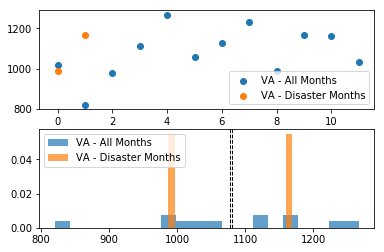

In [108]:
# Checking volumes during disaster months
state1_d_count
state1_v_count = state1_df.groupby(["month_num"])["loan_amnt"].count()

va_v_population = np.array(list(state1_v_count))
va_v_sample = np.array(list(state1_d_count))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(va_v_population)), va_v_population, label="VA - All Months")
plt.scatter(range(len(va_v_sample)), va_v_sample, label="VA - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(va_v_population, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(va_v_sample, 20, density=True, alpha=0.7, label="VA - Disaster Months")
plt.axvline(va_v_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(va_v_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [109]:
stats.ttest_1samp(va_v_sample, va_v_population.mean())

Ttest_1sampResult(statistic=-0.02197802197802198, pvalue=0.9860106088091637)

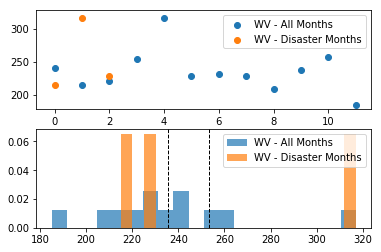

In [110]:
state2_d_count
state2_v_count = state2_df.groupby(["month_num"])["loan_amnt"].count()

wv_v_population = np.array(list(state2_v_count))
wv_v_sample = np.array(list(state2_d_count))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wv_v_population)), wv_v_population, label="WV - All Months")
plt.scatter(range(len(wv_v_sample)), wv_v_sample, label="WV - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wv_v_population, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wv_v_sample, 20, density=True, alpha=0.7, label="WV - Disaster Months")
plt.axvline(wv_v_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wv_v_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [111]:
stats.ttest_1samp(wv_v_sample, wv_v_population.mean())

Ttest_1sampResult(statistic=0.5563567393818534, pvalue=0.6339071188089489)

In [112]:
wv_v_population

array([240, 215, 221, 255, 317, 228, 232, 228, 209, 238, 258, 185])

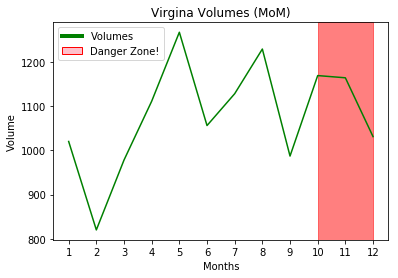

In [133]:
from matplotlib.patches import Patch

# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, va_v_population, color="green", label="Virginia")
legend_elements = [Line2D([0], [0], color='green', lw=4, label='Volumes'),
                   Patch(facecolor='pink', edgecolor='r',
                         label='Danger Zone!')]
plt.legend(loc="best",handles=legend_elements)
plt.title("Virgina Volumes (MoM)")
plt.xlabel("Months")
plt.ylabel("Volume")
plt.axvspan(10, 12, color='red', alpha=0.5, label="Danger Zone!")
plt.xticks(months)
# Print our chart to the screen
plt.show()

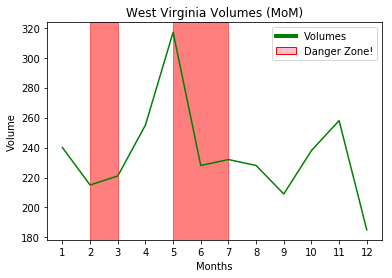

In [134]:
# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, wv_v_population, color="green", label="West Virginia")
legend_elements = [Line2D([0], [0], color='green', lw=4, label='Volumes'),
                   Patch(facecolor='pink', edgecolor='r',
                         label='Danger Zone!')]
plt.legend(loc="best",handles=legend_elements)
plt.title("West Virginia Volumes (MoM)")
plt.xlabel("Months")
plt.ylabel("Volume")
plt.axvspan(2, 3, color='red', alpha=0.5, label="Danger Zone!")
plt.axvspan(5, 7, color='red', alpha=0.5, label="Danger Zone!")
plt.xticks(months)
# Print our chart to the screen
plt.show()